# Encoding Analysis

## Loading data and libs

In [1]:
%matplotlib inline
import sys
sys.path.append("src") # add the source dir

In [2]:
import os
from src.pipeline import Pipeline, MultiPipeline
from mne_bids import BIDSPath
import mne, logging, scipy
import numpy as np
import pandas as pd
from preprocessing import CleaningData, SimpleMNEFilter, PrecomputedICA
from erpanalysis import ERPAnalysis
import seaborn as sns

In [3]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='003', session='P3', task='P3',datatype='eeg', suffix='eeg', root=bids_root)
pipeline = Pipeline(bids_path, verbose=logging.ERROR)
pipeline.load_data()
pipeline.set_montage()
pipeline.set_custom_events_mapping(task='P3')

## Initialize Pipeline and generate Epochs

In [4]:
pipeline.make_pipeline([
    SimpleMNEFilter(1., 60, 'firwin'),
    CleaningData(bids_path),
    PrecomputedICA(bids_path),
    ('reference', ['VEOG_lower']),
    ('resample', 512)
])
erp = ERPAnalysis(-0.2, 0.8, baseline=(None, 0), reject_by_annotation=True)
pipeline.compute_epochs(erp)

Number of events,331
Events,response/correct/201: 152response/error/202: 13stimulus/A/freq/12: 5stimulus/A/freq/13: 4stimulus/A/freq/14: 6stimulus/A/freq/15: 2stimulus/A/rare/11: 7stimulus/B/freq/21: 4stimulus/B/freq/23: 7stimulus/B/freq/24: 8stimulus/B/freq/25: 8stimulus/B/rare/22: 7stimulus/C/freq/31: 10stimulus/C/freq/32: 7stimulus/C/freq/34: 3stimulus/C/freq/35: 9stimulus/C/rare/33: 7stimulus/D/freq/41: 11stimulus/D/freq/42: 7stimulus/D/freq/43: 4stimulus/D/freq/45: 6stimulus/D/rare/44: 7stimulus/E/freq/51: 8stimulus/E/freq/52: 7stimulus/E/freq/53: 6stimulus/E/freq/54: 9stimulus/E/rare/55: 7
Time range,-0.199 – 0.801 sec
Baseline,-0.199 – 0.000 sec


In [5]:
# erp.epochs.equalize_event_counts(pipeline.event_ids)

## Linear Modelling

 $$ y = \beta_0 + \beta_1 * stimulus_A + \beta_2 * stimulus_B + \beta_3 * stimulus_C + \beta_4 * stimulus_D + \beta_5 * stimulus_E + \beta_6 * condition_{rare/freq} $$

In [6]:
epochs = erp.epochs['stimulus'].get_data(picks=['Pz'])
y = epochs.copy() #(events * channels * trials)
y_avg = y.sum(axis=2) * 1e3# convert to minivolts

### Design Matrix

In [7]:
X = np.ones([y.shape[0], 7]) # 8 because we have 8 betas

### Linear equation solver without Regularization

In [8]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X[:,1:], y_avg) # we don't need to pass intercept
incpt, coef = reg.intercept_, reg.coef_

In [9]:
print("Info check: Intercept-only{}, mean:{}".format(incpt,np.mean(y_avg)))

Info check: Intercept-only[-0.12692203], mean:-0.12692203111578523


Looks like this is correct!

### Get events dataframe

In [10]:
df = erp.get_encoding_data('stimulus')
df['Cz'] = y_avg # assign Cz electodes values

Looking at the data

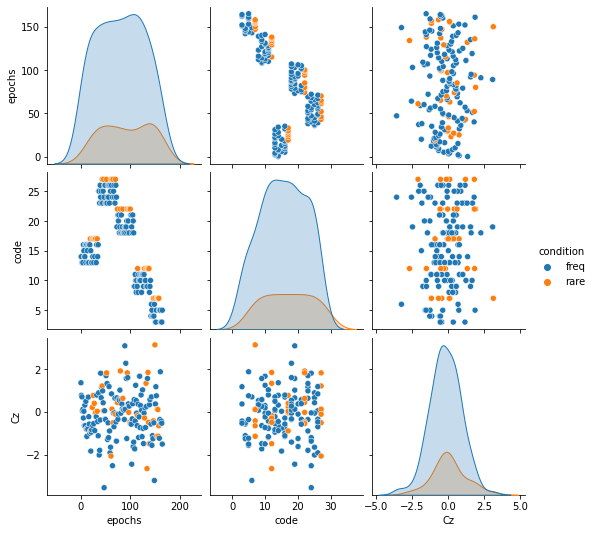

In [11]:
sns.pairplot(df, hue='condition')

We have unequal number of rare and freq evenets

In [12]:
X[np.where(df['condition'] !="rare"), 6] = 0
reg.fit(X[:,1:], y_avg)

LinearRegression()

In [13]:
reg.intercept_, reg.coef_

(array([-0.18102742]),
 array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.25661412]]))

### Sanity check

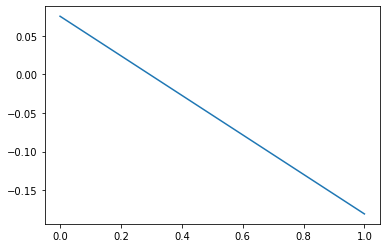

In [14]:
sns.lineplot([0,1],[df.Cz[df.condition=="rare"].mean(), df.Cz[df.condition=="freq"].mean()]);

<AxesSubplot:xlabel='Cz', ylabel='Count'>

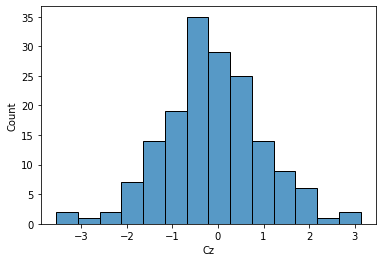

In [15]:
sns.histplot(df.Cz)

### Adding stimulus - A, B, C, D, E to the picture

<AxesSubplot:>

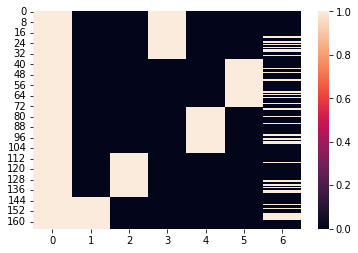

In [16]:
X[np.where(df['stimulus']!="A"),1] = 0
X[np.where(df['stimulus']!="B"),2] = 0
X[np.where(df['stimulus']!="C"),3] = 0
X[np.where(df['stimulus']!="D"),4] = 0
X[np.where(df['stimulus']!="E"),5] = 0
sns.heatmap(X) # design matrix heatmap

In [17]:
reg.fit(X[:,1:], y_avg)
reg.intercept_, reg.coef_

(array([-0.19670104]),
 array([[-0.21790261,  0.04189165, -0.10093479,  0.37737475, -0.100429  ,
          0.27228774]]))

### Sanity check

In [18]:
x_vals = [0,1,2,3,4] # A, B, C, D, E
y_vals_rare = [df.Cz[(df.condition=="rare") & (df.stimulus=="A")].mean(), 
df.Cz[(df.condition=="rare") & (df.stimulus=="B")].mean(), df.Cz[(df.condition=="rare") & (df.stimulus=="C")].mean(),
df.Cz[(df.condition=="rare") & (df.stimulus=="D")].mean(), df.Cz[(df.condition=="rare") & (df.stimulus=="E")].mean()]

y_vals_freq = [df.Cz[(df.condition=="freq") & (df.stimulus=="A")].mean(), 
df.Cz[(df.condition=="freq") & (df.stimulus=="B")].mean(), df.Cz[(df.condition=="freq") & (df.stimulus=="C")].mean(),
df.Cz[(df.condition=="freq") & (df.stimulus=="D")].mean(), df.Cz[(df.condition=="freq") & (df.stimulus=="E")].mean()]

<AxesSubplot:>

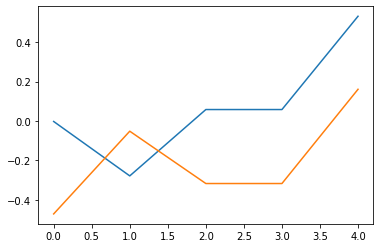

In [19]:
sns.lineplot(x_vals, y_vals_rare)
sns.lineplot(x_vals, y_vals_freq)

In [20]:
coef_ = np.hstack((reg.intercept_.reshape(-1,1), reg.coef_))

In [21]:
X.T  coef_

SyntaxError: invalid syntax (Temp/ipykernel_27164/845446487.py, line 1)

## Mass Univariate

<AxesSubplot:>

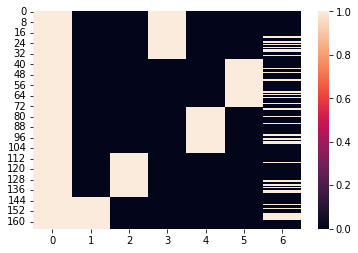

In [ ]:
sns.heatmap(X)

In [ ]:
reg.fit(X[:,1:], y[:,0,:])
reg.intercept_.shape, reg.coef_.shape

((513,), (513, 6))

In [ ]:
betas = np.hstack((reg.intercept_.reshape(-1,1), reg.coef_))
y[:,0,:].shape

(166, 513)

In [ ]:
betas.shape

(513, 7)

In [ ]:
(betas.sum(axis=1)).shape

(513,)

In [ ]:
epocs.times.shape

(513,)

In [ ]:
X_nue = np.ones(20)

<AxesSubplot:>

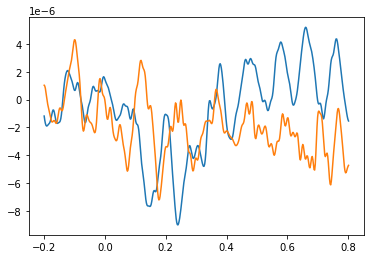

In [ ]:
epocs = erp.epochs['stimulus'].copy()
sns.lineplot(x=epocs.times.reshape(-1), y=betas[:,0])
sns.lineplot(x=epocs.times.reshape(-1), y=betas[:,1])

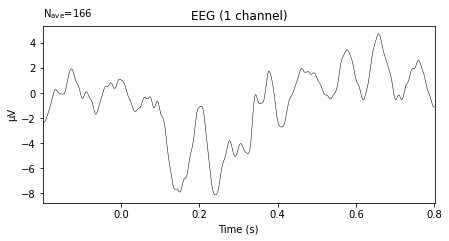

In [ ]:
erp.epochs['stimulus'].average().plot(picks='Cz');

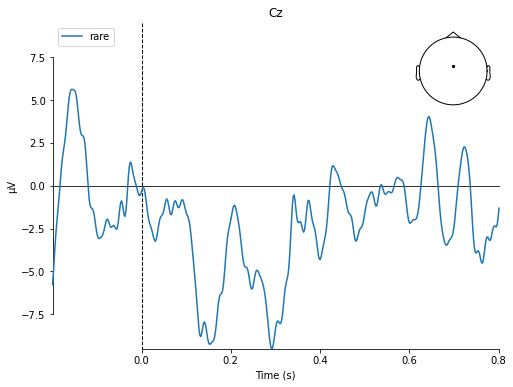

[<Figure size 576x432 with 2 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds({'stimulus': erp.epochs['stimulus'].average(), 'rare': erp.epochs['rare'].average()}, picks=['Cz'])

<AxesSubplot:>

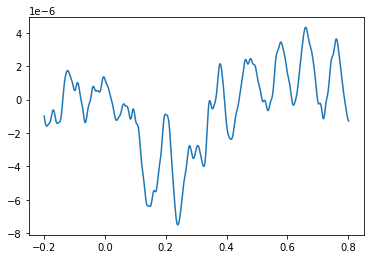

In [ ]:
b_1,res,rnk,s = scipy.linalg.lstsq(X, y[:,0,:])
b_1.shape
sns.lineplot(epocs.times.reshape(-1), b_1.T[:,0])

In [ ]:
X[np.where(df['stimulus']!="A"),1] = 1
X[np.where(df['stimulus']!="B"),2] = 1
X[np.where(df['stimulus']!="C"),3] = 1
X[np.where(df['stimulus']!="D"),4] = 1
X[np.where(df['stimulus']!="E"),5] = 1
X[np.where(df['condition']!="rare"),6] = 1
X[np.where(df['condition']!="freq"),7] = 0

IndexError: index 7 is out of bounds for axis 1 with size 7

<AxesSubplot:>

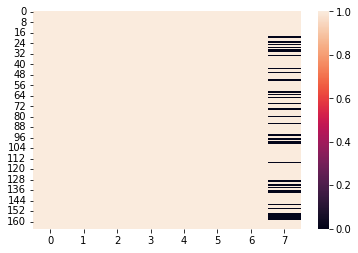

In [ ]:
sns.heatmap(X)

In [ ]:
b_1,res,rnk,s = scipy.linalg.lstsq(X, y_cap[:,0,:])
b_2,res,rnk,s = scipy.linalg.lstsq(X, y_cap[:,0,:])

<AxesSubplot:>

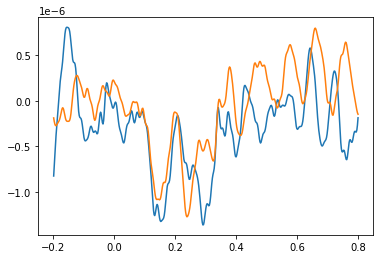

In [ ]:
sns.lineplot(epocs.times.reshape(-1),b_1.T[:,0])
X[np.where(df['condition']!="rare"),6] = 0
X[np.where(df['condition']!="freq"),7] = 1
b_2,res,rnk,s = scipy.linalg.lstsq(X, y_cap[:,0,:])
sns.lineplot(epocs.times.reshape(-1),b_2.T[:,0])

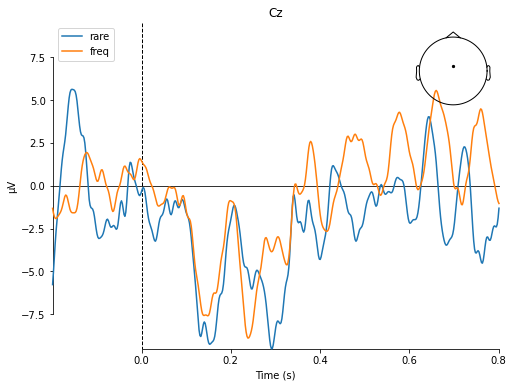

[<Figure size 576x432 with 2 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds({'rare': erp.epochs['rare'].average(), 'freq': erp.epochs['freq'].average()}, picks=['Cz'])